# Clustering tweets about Machine Learning using self-organizing maps

*Arnaud Le Doeuff*
*Ignacio Dorado*
*11/20*

### Usefull Links
- Just some examples https://github.com/RodolfoFerro/pandas_twitter/blob/master/01-extracting-data.md
- Sompy documentation: https://github.com/sevamoo/SOMPY
- Short SOM explanation: https://www.youtube.com/watch?v=K4WuE7zlOZo
- Long SOM explanation: https://www.youtube.com/watch?v=lFbxTlD5R98
- ElsaScola's project: https://github.com/ElsaScola/clustering-tweets-self

### Papers:
- The self-organizing map: https://ieeexplore.ieee.org/abstract/document/58325?casa_token=3Zro_Hz131gAAAAA:VxJDUnoRPoaORVCTpcDbakvllbLsf8fn1A7oHY-oGjuZCsP-cxTJ4obczEmTFLj0gRwwbQo_3KE
- World Cup: https://arxiv.org/abs/1408.5427
    - Reference for RTs removal
- Outbreaks: https://dl.acm.org/doi/10.1145/2487788.2488172

## Index

1. <a href='#section1'> Capture the tweets</a>

    1.1 <a href='#section1.1'> Set up the twitter API</a>
    
    1.2 <a href='#section1.2'> Search the API for our query</a>
    
    1.3 <a href='#section1.3'> Creating a pandas DataFrame</a>
    
    

2. <a href='#section2'> Preprocessing</a>

    2.1 <a href='#section2.1'> Cleaning the strings</a>
    
    2.2 <a href='#section2.2'> Creating the dictionary</a>
    
    2.3 <a href='#section2.3'> Creating and reducing the vectorize representations</a>
    
    
3. <a href='#section3'> Clustering</a>

    3.1 <a href='#section3.1'> Dimensionality reduction (PCA)</a>
    
    3.2 <a href='#section3.2'> Trainning (SOM)</a>
    
    3.3 <a href='#section3.3'> Visualize the clusters </a>
    
    3.4 <a href='#section3.4'> Word Cloud</a>
    
    
 4. <a href='#section4'> Discuss the results</a>   

## Module importation

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import sompy3
import tweepy
import csv
import re

from tensorflow.keras.preprocessing import text
from sklearn.decomposition import PCA
from wordcloud import WordCloud

<a id='section1'></a>
## 1. Capture the tweets

<a id='section1.1'></a>
### 1.1 Set up the Twitter  API

Talk about twitter api, credentials and stafff...

In [2]:
# Import our credentials variables from an external file, for privacy
from credentials import * 

def twitter_setup():
    """
    Function to setup the Twitter's API
    with our access keys provided.
    """
    # Authentication and access using keys
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    return api

In [3]:
# Create an extractor object:
extractor = twitter_setup()

<a id='section1.2'></a>
### 1.2 Search the API for our query

Twitter will only allow us to download 3200 tweets every 15 minutes, which is not a lot considering most of them are retweeets. Only 7 days (or so) can be retrieved.

- wait_rate_limit
- full text

In [4]:
# Define the text pattern we want to search for
searchQuery = "machine learning"

# Maximum number of tweets to be retrieved
maxTweets = 10000

# Show our current limitations
print(extractor.rate_limit_status()['resources']['search'])

{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1606125400}}


In [5]:
# Counter for the total number of requested tweets and the number of non RT tweets
tweet_count = 0
global_count = 0
tweets=[]

# Search the api using a cursor with our query and our maximum limit
for tweet in tweepy.Cursor(extractor.search,q=searchQuery, tweet_mode='extended').items(maxTweets):
    
    # Verify the tweet is not a RT
    if not tweet.full_text.startswith("RT "):
            tweets.append(tweet)
            tweet_count += 1
    global_count += 1 
    
    # Inform our current progress
    if (global_count%1000 == 0):
        print("Downloaded {0} tweets".format(global_count))
        print("Kept {0} non RT tweets".format(tweet_count))
        print("---------------------------")
    

# Display the final number of collected tweets
print("Downloaded {0} tweets".format(global_count))
print("Kept {0} non RT tweets".format(tweet_count))

Downloaded 1000 tweets
Kept 238 non RT tweets
---------------------------
Downloaded 2000 tweets
Kept 450 non RT tweets
---------------------------


Rate limit reached. Sleeping for: 794


Downloaded 3000 tweets
Kept 638 non RT tweets
---------------------------
Downloaded 4000 tweets
Kept 882 non RT tweets
---------------------------
Downloaded 5000 tweets
Kept 1102 non RT tweets
---------------------------


Rate limit reached. Sleeping for: 804


Downloaded 6000 tweets
Kept 1307 non RT tweets
---------------------------
Downloaded 7000 tweets
Kept 1578 non RT tweets
---------------------------


Rate limit reached. Sleeping for: 789


Downloaded 8000 tweets
Kept 1827 non RT tweets
---------------------------
Downloaded 9000 tweets
Kept 2081 non RT tweets
---------------------------
Downloaded 10000 tweets
Kept 2302 non RT tweets
---------------------------
Downloaded 10000 tweets
Kept 2302 non RT tweets


Inspect the format of the collected dataset

In [6]:
print ("Type of tweets: " + str(type(tweets)))
print ("Type of each tweet: " + str(type(tweets[0])))

Type of tweets: <class 'list'>
Type of each tweet: <class 'tweepy.models.Status'>


In [7]:
print(dir(tweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'display_text_range', 'entities', 'extended_entities', 'favorite', 'favorite_count', 'favorited', 'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'truncated', 'user']


<a id='section1.3'></a>
### 1.3 Creating a pandas DataFrame

In order to organize the data, read and write to files faster, we use a Pandas Data Frame
- Other information porque sí

In [8]:
# Create a pandas DataFrame
df = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['Tweets'])

# Add all the information we consider relevant
df['len']  = np.array([len(tweet.full_text) for tweet in tweets])
df['ID']   = np.array([tweet.id for tweet in tweets])
df['Date'] = np.array([tweet.created_at for tweet in tweets])
df['Source'] = np.array([tweet.source for tweet in tweets])
df['Likes']  = np.array([tweet.favorite_count for tweet in tweets])
df['RTs']    = np.array([tweet.retweet_count for tweet in tweets])

# Display the first 10 elements of the dataframe:
pd.set_option('display.max_colwidth', 60)
display(df.head(100))

,Tweets,len,ID,Date,Source,Likes,RTs
0,SICK’s Deep Learning brings simplicity to complex AI ins...,303,1329334610946260992,2020-11-19 08:04:03,dlvr.it,0,0
1,Google Cloud Debuts Professional Machine Learning Engine...,103,1329334598455734277,2020-11-19 08:04:00,Paper.li,0,0
2,Bringing your own custom container image to Amazon SageM...,142,1329334594085269506,2020-11-19 08:03:59,HubSpot,0,0
3,Here’s what machines need to understand in order to trul...,238,1329334592449507331,2020-11-19 08:03:59,HubSpot,0,0
4,Level up your data science vocabulary: Geometric Distrib...,121,1329334535532670977,2020-11-19 08:03:45,DeepAI,0,0
...,...,...,...,...,...,...,...
95,5 Most Useful Machine Learning Tools every lazy full-sta...,124,1329322590670893059,2020-11-19 07:16:17,Paper.li,2,1
96,The way we train AI is fundamentally flawed https://t.co...,67,1329322554541154306,2020-11-19 07:16:09,Twitter for Android,3,1
97,Machine Learning: MLflow 1.12 verbessert die PyTorch-Int...,100,1329322407811801088,2020-11-19 07:15:34,Paper.li,0,0
98,"Your fleet is in safe hands with #JupiCar, an innovative...",296,1329322279893950464,2020-11-19 07:15:03,Twitter Web App,0,2


Now we save the Data Frame it to a csv file so we can read it every time

In [9]:
df.to_csv('tweets.csv', index=False)

In [89]:
df = pd.read_csv("tweets(2302).csv")

<a id='section2'></a>
## 2. Preprocessing

<a id='section2.1'></a>
### 2.1 Cleaning the strings

In [90]:
def clean_str(string):
    """
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"@[^\s]+", " ", string)             #remove account tags   
    string = re.sub(r"http[^\s]+", " ", string)          #remove urls
    string = re.sub(r"#", " ", string)                   #remove hastag symbol
    string = re.sub(r"[^A-Za-z\']", " ", string)         #remove everything but letters and nummbers(?)
    string = re.sub(r"\'s", " is", string)               #split 's contractions
    string = re.sub(r"\'ve", " have", string)            #split 's contractions
    string = re.sub(r"n\'t", " not", string)             #split n't contractions
    string = re.sub(r"\'re", " are", string)             #split 're contractions
    string = re.sub(r"\'d", " would", string)            #split 'd contractions
    string = re.sub(r"\'ll", " will", string)            #split 'll contractions
    string = re.sub(r"\'", " ", string)                  #remove '
    string = re.sub(r"!", " ! ", string)                 #split !
    string = re.sub(r"\?", " \? ", string)               #split ?
    string = re.sub(r"\s{2,}", " ", string)              #remove more than 1 white space
    return string.strip().lower()            #remove start and end white spaces

In [91]:
# Clean the strings in our DataFrame
df['Tweets'] = df['Tweets'].apply(clean_str)

# Display the full text for the first 3 elements
pd.set_option('display.max_colwidth', None)
display(df.head(3))

,Tweets,len,ID,Date,Source,Likes,RTs
0,sick s deep learning brings simplicity to complex ai inspection sick has launched a suite of deep learning apps and services to simplify machine vision quality inspection for challenging food products and agricultural produce especially those that have,303,1329334610946260992,2020-11-19 08:04:03,dlvr.it,0,0
1,google cloud debuts professional machine learning engineer certification cloud,103,1329334598455734277,2020-11-19 08:04:00,Paper.li,0,0
2,bringing your own custom container image to amazon sagemaker studio notebooks datascience machinelearning,142,1329334594085269506,2020-11-19 08:03:59,HubSpot,0,0


<a id='section2.2'></a>
### 2.2 Creating the dictionary

Justify why we did it in count mode and not in binary mode

In [92]:
# Create the tokenizer
tokenizer = text.Tokenizer()

# Tensorflow tokenizer requires a list as input
train_tweets = df['Tweets'].values.tolist()

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_tweets)

# Get the dictionaries
word_index = tokenizer.word_index     # map each word to a unique index (ordered by frequency)
word_count = tokenizer.word_counts    # map each word to its number of ocurrences

In [93]:
# Display the number of different words that were found in our dataset
print("There are " + str(len(word_index)) + " unique tokens.\n")

# Show the most common words in our tweets
print("Show the most frequent word index:")
for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=True)):
    print('   {} ({}) --> {}'.format(word, word_count[word], word_index[word]))
    if i == 20: 
        break

# Show the less common words in our tweets
print("\nShow the least frequent word index:")
for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=False)):
    print('   {} ({}) --> {}'.format(word, word_count[word], word_index[word]))
    if i == 10: 
        break

There are 8037 unique tokens.

Show the most frequent word index:
   learning (2093) --> 1
   machine (1927) --> 2
   the (1273) --> 3
   to (1242) --> 4
   and (1181) --> 5
   a (857) --> 6
   of (756) --> 7
   is (739) --> 8
   in (728) --> 9
   ai (655) --> 10
   for (595) --> 11
   data (403) --> 12
   with (402) --> 13
   machinelearning (393) --> 14
   i (378) --> 15
   on (365) --> 16
   it (340) --> 17
   that (287) --> 18
   you (286) --> 19
   we (274) --> 20
   ml (238) --> 21

Show the least frequent word index:
   simplicity (1) --> 3448
   simplify (1) --> 3449
   container (1) --> 3450
   dataquality (1) --> 3451
   datateams (1) --> 3452
   geometric (1) --> 3453
   geometricdistribution (1) --> 3454
   flexes (1) --> 3455
   muscles (1) --> 3456
   wasn (1) --> 3457
   xataka (1) --> 3458


<a id='section2.3'></a>
### 2.3 Creating and reducing the vectorize representation

We have 7396 unique words in our dictionary, now we have to decide where to prune the dictionary
- Probably we need to remove the **most frequent** articles
    - I'll take away the 30 most frequent words (provisional)
- We will also remove the **least frequent** words by keeping only the 1000 most frequent words
    - We could think about increasing this number to get a better perfromance

In [94]:
# We will only get the 1000 most frequent words
# From those, the 30 most common words will be remove
tokenizer.num_words = 1000
nb_words_to_remove = 15

# Vectorize texts into one-hot enconding representations
train_vectors = tokenizer.texts_to_matrix(train_tweets, mode='count')

# Delete the vectors columns corresponding to most common words
train_vectors_reduced = np.delete(train_vectors, range(nb_words_to_remove), 1)

# Show the first tweet and its vector representation
np.set_printoptions(threshold=100)
print('First tweet: ' + train_tweets[0])
print('\nVector representation of the first tweet:\n' + str(train_vectors[0]))

# Show the current shape of our dataset
print('\nShape of the training set (nb_examples, vector_size): ' + str(train_vectors.shape))

First tweet: sick s deep learning brings simplicity to complex ai inspection sick has launched a suite of deep learning apps and services to simplify machine vision quality inspection for challenging food products and agricultural produce especially those that have

Vector representation of the first tweet:
[0. 2. 1. ... 0. 0. 0.]

Shape of the training set (nb_examples, vector_size): (2302, 1000)


<a id='section3'></a>
## 3. Clustering

<a id='section3.1'></a>
### 3.1 Dimensionality reduction (PCA)

We reduce dimensions from 970 features to 2 features. Then we display all the data.
- Explain the variance decision (should be more than 60%)

In [95]:
print("Original shape of our dataset: " + str(train_vectors_reduced.shape))

# Reduce the dimensions to 2 components
pca = PCA(n_components=2)
vectors2d = pca.fit_transform(train_vectors_reduced)

print("New shape of our dataset: " + str(vectors2d.shape))
print("Variance of each component: " + str(pca.explained_variance_))

Original shape of our dataset: (2302, 985)
New shape of our dataset: (2302, 2)
Variance of each component: [0.56503977 0.35443949]


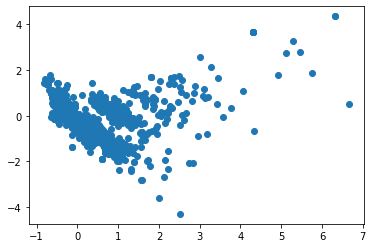

In [96]:
# Plot our current 2d dataset
fig = plt.figure()
plt.plot(vectors2d[:,0], vectors2d[:,1],'o')
plt.show(fig)

<a id='section3.2'></a>
### 3.2 Trainnig (SOM)

Now we create our model with 20\*20 neurons and train it
- Using sompy

In [129]:
# The number of neurons: 20*20
mapsize = [20, 20] 
som = sompy3.SOMFactory.build(vectors2d, mapsize, normalization=None)
som.train(n_job=1, verbose='info') 

INFO:root: Training...
INFO:root: pca_linear_initialization took: 0.016000 seconds
INFO:root: Rough training...
INFO:root: radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 6

INFO:root: epoch: 1 ---> elapsed time:  0.112000, quantization error: 0.250367

INFO:root: epoch: 2 ---> elapsed time:  0.120000, quantization error: 0.132032

INFO:root: epoch: 3 ---> elapsed time:  0.114000, quantization error: 0.096359

INFO:root: epoch: 4 ---> elapsed time:  0.120000, quantization error: 0.082458

INFO:root: epoch: 5 ---> elapsed time:  0.120000, quantization error: 0.070646

INFO:root: epoch: 6 ---> elapsed time:  0.120000, quantization error: 0.059206

INFO:root: Finetune training...
INFO:root: radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 7

INFO:root: epoch: 1 ---> elapsed time:  0.120000, quantization error: 0.049696

INFO:root: epoch: 2 ---> elapsed time:  0.120000, quantization error: 0.047813

INFO:root: epoch: 3 ---> elapsed time:  0.120000, quantization error: 0.04

In [132]:
def showHeatmaps (component1, component2):
    # Two heatmaps, one per component
    sns.heatmap(component1, vmax=np.max(som.codebook.matrix), vmin=np.min(som.codebook.matrix))
    plt.ylim(0, component1.shape[0])
    plt.show()
    sns.heatmap(component2, vmax=np.max(som.codebook.matrix), vmin=np.min(som.codebook.matrix))
    plt.ylim(0, component2.shape[0])
    plt.show()

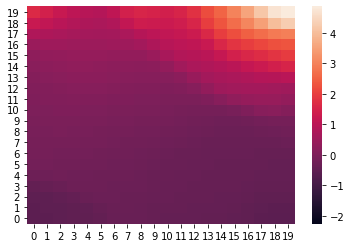

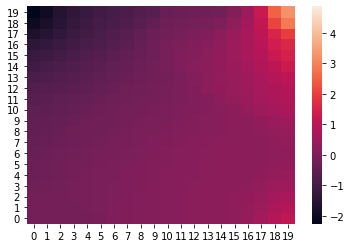

In [134]:
# We select the two components (dimensions) in the map, and reshape them
c1 = som.codebook.matrix[:, 0].reshape(mapsize)    #array of neuron weights for the first component
c2 = som.codebook.matrix[:, 1].reshape(mapsize)    #array of neuron weights for the second component
showHeatmaps(c1, c2)

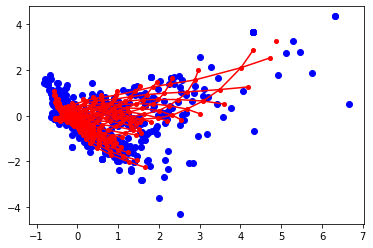

In [135]:
plt.plot(vectors2d[:,0], vectors2d[:,1],'o', c="b")
plt.plot(som.codebook.matrix[:, 0], som.codebook.matrix[:, 1], "o", c="r", markersize=4)
for i in range(c1.shape[0]-1):
    for j in range(c2.shape[1]-1):
        plt.plot(c1[i, j:j+2], c2[i, j:j+2], c="r")
        plt.plot(c1[i:i+2, j], c2[i:i+2, j], c="r")

<a id='section'></a>
### 3.3 Visualize the clusters

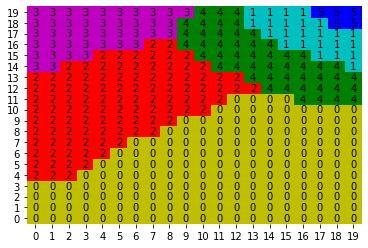

In [150]:
nb_clusters = 6

# Get the cluster label associated to each neuron (cl)
cl = som.cluster(n_clusters=nb_clusters)

# Print each neuron with a different color for each cluster
cmap = ["y", "c", "r", "m", "g", "b"]
cluster_space = som.cluster_labels.reshape(mapsize)
sns.heatmap(cluster_space, annot=True, cmap=cmap, annot_kws={"c": "k"}, cbar=False)
plt.ylim(0, mapsize[0])
plt.show()

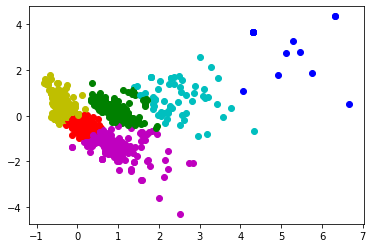

In [151]:
# projected_data is a list with the best matching unit for each input vector
projected_data = som.project_data(vectors2d)
# clusters contains the cluster associated with each input
clusters = cl[projected_data]

for i in range(vectors2d.shape[0]):
    plt.plot(vectors2d[i,0], vectors2d[i,1],'o', c=cmap[clusters[i]])

In [158]:
def UMat(c1, c2):
    """
    Function to get the U-Matrix
    """
    dists = np.zeros(c1.shape)
    for i in range(c1.shape[0]):
        for j in range(c2.shape[1]):
            cnt = 0
            if i > 0:
                dists[i, j] += np.sqrt((c1[i-1, j] - c1[i, j])**2 + (c2[i-1, j] - c2[i, j])**2)
                cnt += 1
            if j > 0:
                dists[i, j] += np.sqrt((c1[i, j-1] - c1[i, j])**2 + (c2[i, j-1] - c2[i, j])**2)
                cnt += 1
            if j < c2.shape[1]-1:
                dists[i, j] += np.sqrt((c1[i, j+1] - c1[i, j])**2 + (c2[i, j+1] - c2[i, j])**2)
                cnt += 1
            if i < c2.shape[1]-1:
                dists[i, j] += np.sqrt((c1[i+1, j] - c1[i, j])**2 + (c2[i+1, j] - c2[i, j])**2)
                cnt += 1
            dists[i, j] /= cnt
    return dists

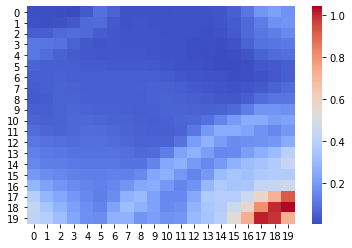

In [165]:
umat = UMat(c1, c2)
sns.heatmap(umat, cmap='coolwarm')
plt.show()

<a id='section3.4'></a>
### 3.4 Word Cloud

First thing, we create a list for the tweets in eaach of the clusters

In [154]:
def getWord (index):
    """
    Function to get the string associated
    to each index (reverse word_index)
    """
    index += nb_words_to_remove
    word = ""
    for key, value in word_index.items():
        if (value == index):
            word = key
            break
    return word

def getClusterWords(words_vectors):
    """
    Function to get all words present in each 
    cluster, words may appear more than once
    """
    
    cluster_words = []
    for c in range(nb_clusters):
        cluster_words.append([])
        
    for tweet in range(len(clusters)):
        for word in range(words_vectors.shape[1]):
            for ocurrences in range(int(words_vectors[tweet][word])):
                cluster_words[clusters[tweet]].append(getWord(word))
                
    return cluster_words

In [155]:
cluster_words = getClusterWords(train_vectors_reduced)

Now we make the word clouds

In [156]:
def concatenate(strings_list):
    """
    Function to transform a list of
    strings into a single string
    """
    text = ""
    for string in strings_list:
        text += string + " "
    return text
    
    
def displayWordCloud(text, max_words):
    """
    Function to display the Word Cloud of a text
    with a specific maximum of words
    """
    wordcloud = WordCloud(max_words=max_words, background_color="white").generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

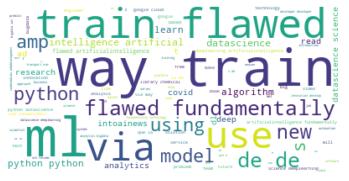

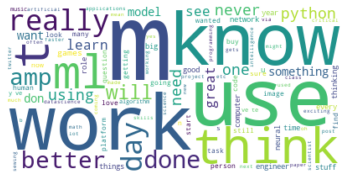

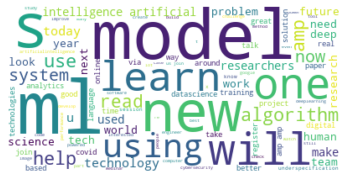

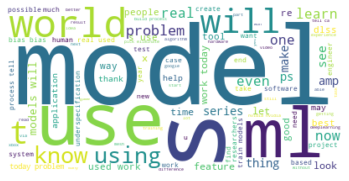

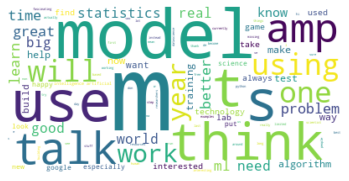

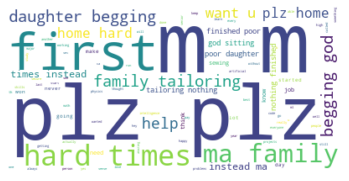

In [157]:
max_words = 100

for cluster in cluster_words:
    text = concatenate(cluster)
    displayWordCloud(text, max_words)

<a id='section4'></a>
## 4. Discuss the results